In [17]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# create empty datset with column year and question_category
df = pd.DataFrame(columns=['year', 'question_category'])

# questions 

dic = {'year': [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,2023],
         'question_category': ['POM','MI','POM','MDTM','MDTM','MDTM','FNL','FNL','MI','RDUH','MI','FNL','SHM','MDTM','SHM','RDUH','FNL','MI','MDTM','MDTM','MI','SHM','MDTM','TG','RDUH','POM','FNL','SHM','FNL','SHM']}


df = pd.DataFrame(dic)


# Encode question categories
le = LabelEncoder()
df['question_category_encoded'] = le.fit_transform(df['question_category'])

# filter the df up to 2019
df = df[df['year'] < 2023]

# Create sequences
sequence_length = 5  # Length of the input sequence
data = []
labels = []
for i in range(len(df) - sequence_length):
    seq = df['question_category_encoded'].values[i:i+sequence_length]
    label = df['question_category_encoded'].values[i+sequence_length]
    data.append(seq)
    labels.append(label)

# Convert to PyTorch tensors
data = torch.tensor(data)
labels = torch.tensor(labels)

import torch
import torch.nn as nn
import torch.optim as optim

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Attention layer
        self.attention = nn.Linear(hidden_size, 1)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        
        # Attention weights
        attn_weights = torch.tanh(self.attention(out))  # Shape: (batch_size, seq_length, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Normalize over the time dimension
        
        # Weighted sum of LSTM outputs based on attention weights
        context_vector = torch.sum(attn_weights * out, dim=1)  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer
        output = self.fc(context_vector)  # Shape: (batch_size, output_size)
        
        return output

# Model hyperparameters
input_size = 1  # Each category is represented by a single number
hidden_size = 64  # Number of LSTM units
output_size = len(le.classes_)  # Number of categories to predict
num_layers = 1


# Hyperparameters
input_size = 1  # Each category is encoded as a single integer
hidden_size = 64
output_size = len(le.classes_)  # Number of unique categories
num_layers = 1
num_epochs = 400
batch_size = 4
learning_rate = 0.001

# Prepare DataLoader
class QuestionCategoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.unsqueeze(-1).float()  # Add a feature dimension
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


dataset = QuestionCategoryDataset(data, labels)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = LSTMWithAttention(input_size, hidden_size, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Initialize list to store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0  # Accumulate loss over an epoch
    for sequences, targets in train_loader:
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')



Epoch [10/400], Loss: 1.8241
Epoch [20/400], Loss: 1.7791
Epoch [30/400], Loss: 1.7566
Epoch [40/400], Loss: 1.7114
Epoch [50/400], Loss: 1.6426
Epoch [60/400], Loss: 1.5817
Epoch [70/400], Loss: 1.5356
Epoch [80/400], Loss: 1.4762
Epoch [90/400], Loss: 1.4222
Epoch [100/400], Loss: 1.3523
Epoch [110/400], Loss: 1.3034
Epoch [120/400], Loss: 1.2047
Epoch [130/400], Loss: 1.1303
Epoch [140/400], Loss: 1.0422
Epoch [150/400], Loss: 0.9651
Epoch [160/400], Loss: 0.8862
Epoch [170/400], Loss: 0.8307
Epoch [180/400], Loss: 0.7525
Epoch [190/400], Loss: 0.6830
Epoch [200/400], Loss: 0.6137
Epoch [210/400], Loss: 0.5493
Epoch [220/400], Loss: 0.4867
Epoch [230/400], Loss: 0.4229
Epoch [240/400], Loss: 0.3713
Epoch [250/400], Loss: 0.3252
Epoch [260/400], Loss: 0.2819
Epoch [270/400], Loss: 0.2452
Epoch [280/400], Loss: 0.2145
Epoch [290/400], Loss: 0.1867
Epoch [300/400], Loss: 0.1643
Epoch [310/400], Loss: 0.1466
Epoch [320/400], Loss: 0.1304
Epoch [330/400], Loss: 0.1174
Epoch [340/400], Lo

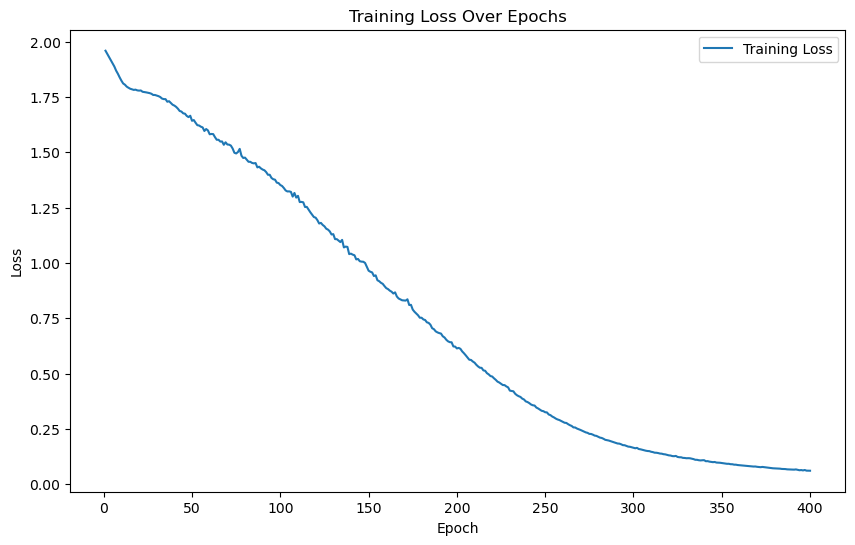

In [18]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [19]:
import numpy as np

# Define the sequence length used during training, e.g., 5
# sequence_length = 10

# Prepare the latest sequence from the data
# Use the last 5 question categories as the input sequence
latest_sequence = df['question_category'].iloc[-sequence_length:].values
latest_sequence = le.transform(latest_sequence)  # Encode categories
latest_sequence = torch.tensor(latest_sequence, dtype=torch.long).unsqueeze(0).unsqueeze(-1)  # Shape: (1, sequence_length, 1)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Predict next category
    output = model(latest_sequence.float())
    probabilities = nn.functional.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    predicted_category_index = np.argmax(probabilities)
    predicted_category = le.inverse_transform([predicted_category_index])[0]

# Display the results
probabilities_dict = dict(zip(le.classes_, probabilities))
print("Probabilities for each category:", probabilities_dict)
print("Predicted category for the next year:", predicted_category)

Probabilities for each category: {'FNL': 0.0025474888, 'MDTM': 0.8568627, 'MI': 0.01663176, 'POM': 0.00021789754, 'RDUH': 7.4418116e-05, 'SHM': 0.12366014, 'TG': 5.5780806e-06}
Predicted category for the next year: MDTM


In [20]:
# sort the dictionary by value
sorted_dict = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True))
print("Sorted probabilities for each category:", sorted_dict)

Sorted probabilities for each category: {'MDTM': 0.8568627, 'SHM': 0.12366014, 'MI': 0.01663176, 'FNL': 0.0025474888, 'POM': 0.00021789754, 'RDUH': 7.4418116e-05, 'TG': 5.5780806e-06}


In [21]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Create empty dataset with column year and question_category
dic = {'year': [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
       'question_category': ['POM', 'MI', 'POM', 'MDTM', 'MDTM', 'MDTM', 'FNL', 'FNL', 'MI', 'RDUH', 'MI', 'FNL', 'SHM', 'MDTM', 'SHM', 'RDUH', 'FNL', 'MI', 'MDTM', 'MDTM', 'MI', 'SHM', 'MDTM', 'TG', 'RDUH', 'POM', 'FNL', 'SHM', 'FNL', 'SHM']}

df = pd.DataFrame(dic)

# Encode question categories
le = LabelEncoder()
df['question_category_encoded'] = le.fit_transform(df['question_category'])

# Filter the df up to 2019
df = df[df['year'] < 2023]

# Create sequences
sequence_length = 5  # Length of the input sequence
data = []
labels = []
for i in range(len(df) - sequence_length):
    seq = df['question_category_encoded'].values[i:i + sequence_length]
    label = df['question_category_encoded'].values[i + sequence_length]
    data.append(seq)
    labels.append(label)

# Convert to PyTorch tensors
data = torch.tensor(data)
labels = torch.tensor(labels)

# Define the Transformer-based model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, nhead=1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        x = self.embedding(x)  # Shape: (batch_size, seq_length, hidden_size)
        x = x.permute(1, 0, 2)  # Change to (seq_length, batch_size, hidden_size)
        x = self.transformer_encoder(x)  # Shape: (seq_length, batch_size, hidden_size)
        x = x.mean(dim=0)  # Take the mean of the sequence output
        x = self.fc(x)  # Shape: (batch_size, output_size)
        return x

# Model hyperparameters
input_size = 1  # Not used in this model
hidden_size = 64  # Number of hidden units
output_size = len(le.classes_)  # Number of unique categories
num_layers = 1  # Number of transformer encoder layers
nhead = 4  # Number of heads in multihead attention

# Hyperparameters
num_epochs = 300
batch_size = 4
learning_rate = 0.001

# Prepare DataLoader
class QuestionCategoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = QuestionCategoryDataset(data, labels)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = TransformerModel(input_size, hidden_size, output_size, num_layers, nhead)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize list to store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0  # Accumulate loss over an epoch
    for sequences, targets in train_loader:
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


/Users/h6x/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/300], Loss: 1.1423
Epoch [20/300], Loss: 0.5992
Epoch [30/300], Loss: 0.4812
Epoch [40/300], Loss: 0.3231
Epoch [50/300], Loss: 0.3434
Epoch [60/300], Loss: 0.3332
Epoch [70/300], Loss: 0.2746
Epoch [80/300], Loss: 0.2675
Epoch [90/300], Loss: 0.2674
Epoch [100/300], Loss: 0.2219
Epoch [110/300], Loss: 0.2346
Epoch [120/300], Loss: 0.2332
Epoch [130/300], Loss: 0.2518
Epoch [140/300], Loss: 0.4727
Epoch [150/300], Loss: 0.2583
Epoch [160/300], Loss: 0.2808
Epoch [170/300], Loss: 0.2198
Epoch [180/300], Loss: 0.2644
Epoch [190/300], Loss: 0.2277
Epoch [200/300], Loss: 0.2296
Epoch [210/300], Loss: 0.1871
Epoch [220/300], Loss: 0.2132
Epoch [230/300], Loss: 0.2158
Epoch [240/300], Loss: 0.2448
Epoch [250/300], Loss: 0.2940
Epoch [260/300], Loss: 0.2501
Epoch [270/300], Loss: 0.1920
Epoch [280/300], Loss: 0.2584
Epoch [290/300], Loss: 0.2327
Epoch [300/300], Loss: 0.2435


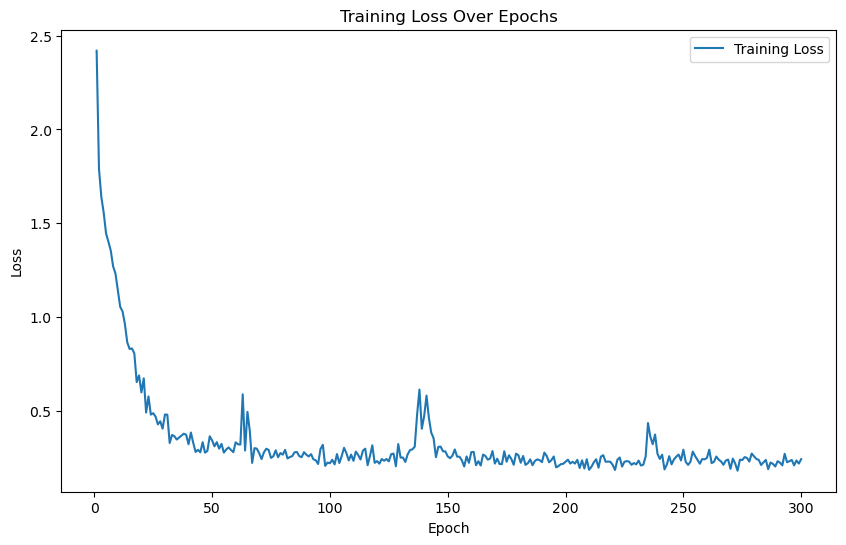

In [22]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [23]:
# Assuming the model has been trained already and you want to predict the next year based on the last available sequence
# Get the last sequence from the dataframe
last_sequence = df['question_category_encoded'].values[-sequence_length:]

# Convert the last sequence to a tensor and add a batch dimension
input_tensor = torch.tensor(last_sequence).unsqueeze(0)  # Shape: (1, sequence_length)

# Make prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_output = model(input_tensor)  # Shape: (1, output_size)
    predicted_category_encoded = torch.argmax(predicted_output, dim=1)  # Get the index of the maximum score

# Decode the predicted category
predicted_category = le.inverse_transform(predicted_category_encoded.numpy())

print(f'The predicted question category for the next year is: {predicted_category[0]}')

# Display the probabilities for each category
probabilities = nn.functional.softmax(predicted_output, dim=1).squeeze().detach().numpy()
probabilities_dict = dict(zip(le.classes_, probabilities))
print("Probabilities for each category:", probabilities_dict)

# sort the dictionary by value
sorted_dict = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True))
print("Sorted probabilities for each category:", sorted_dict)




The predicted question category for the next year is: FNL
Probabilities for each category: {'FNL': 0.92989224, 'MDTM': 0.02025036, 'MI': 0.008351856, 'POM': 1.2772008e-05, 'RDUH': 3.716797e-05, 'SHM': 0.04141023, 'TG': 4.5356162e-05}
Sorted probabilities for each category: {'FNL': 0.92989224, 'SHM': 0.04141023, 'MDTM': 0.02025036, 'MI': 0.008351856, 'TG': 4.5356162e-05, 'RDUH': 3.716797e-05, 'POM': 1.2772008e-05}
